In [110]:
import os
HOME = os.getcwd()

In [111]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

***scommentare le righe di codice se lo si vuole caricare***

# Caricare i pesi e istanziare il modello

Per caricare il modello a partire dai pesi che abbiamo salvato (cartella con tutti i pesi salvati https://drive.google.com/drive/folders/1C_gbs3u8XcdAeOGImWvidZHj7BTpTDcH?usp=sharing), ci basta:

In [112]:
# Pip install method (recommended)
!pip install natsort
from natsort import natsorted
!pip install ultralytics==8.0.20
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.8/78.2 GB disk)


In [113]:
from ultralytics import YOLO
from google.colab import drive

# Lista dei possibili pesi
weigth_list = [
    "old_object_25epochs_aug_pretrained_weights_2023-09-15_09-25-53.pt",
    "old_object_5epochs_no_aug_pretrained_weights_2023-09-19_14-48-36.pt",
    "new_object_25epochs_aug_pretrained_weights_2023-08-25_17-54-59.pt",
    "new_object_5epochs_no_aug_pretrained_weights_2023-09-19_15-20-25.pt",
    "old_object_10epochs_no_aug_pretrained_weights_2023-09-22_20-34-31.pt",
    "new_object_10epochs_no_aug_pretrained_weights_2023-09-22_20-20-05.pt",
]
special = "nospecial"
!cd {HOME}


weigth_filename = weigth_list[3].split('.')[0]

# dimensione delle immagini utilizzate per allenare il modello
TRAINING_WIDTH = 640
TRAINING_HEIGHT = 640

# Carichiamo i pesi
drive.mount('/content/gdrive')
!cp {HOME}/gdrive/"My Drive"/texting_and_driving/weights/{weigth_filename}.pt {HOME}

drive.flush_and_unmount()

model = YOLO(f'{weigth_filename}.pt')

Mounted at /content/gdrive


In [114]:
print(weigth_filename)

new_object_5epochs_no_aug_pretrained_weights_2023-09-19_15-20-25


Per prima cosa dobbiamo scegliere la dimensione della finestra di immagini da considerare per la valutazione tramite la nostra euristica

In [115]:
# PARAMETRI DI CONFIGURAZIONE
window_size = 10

In [116]:
# X, oggetti che possono apparire in un frame (driver-window, driver-seat-belt, passenger-window, passenger-seat-belt, passenger-)
X = model.names
print(X)

{0: 'driver-seat-belt', 1: 'driver-sun-visor', 2: 'driver-window', 3: 'passenger-grab-handle', 4: 'passenger-seat-belt', 5: 'passenger-sun-visor', 6: 'passenger-window'}


In [117]:
# Ritorna la classe dell'oggetto speciale se presente (per classificarlo senza utilizzare alcuna euristica), altrimenti None
# questa funzione è utile per evitare di classificare il frame con un euristica sapendo che un determinato oggetto è caratterizzante di una classe (e.g. passenger-grab-handle)
def has_special_object(X, results, conf_treshold = 0.7, special_objects_names = []):
  if special == "nospecial":
    return None
  index = 0
  for r in results:
    for index in range(0, len(r.boxes.cls)):
      for special_object in special_objects_names:
        if special_object in X[int(r.boxes.cls[index])] and float(r.boxes.conf[index]) > conf_treshold:
          if "passenger" in special_object:
            return "passenger"
          elif "driver" in special_object:
            return "driver"
  return None

In [118]:
SPECIAL_OBJ_TRESHOLD = 0.8

## Cardinalità delle $k\text{-class-bb}$ (baseline)

In [119]:
def baseline(results, special_objects_names):
  # Numero di bounding box di oggetti della classe driver riconosciuti nel frame corrente dal modello
  driver_class_bb_cardinality = 0
  # Numero di bounding box di oggetti della classe passenger riconosciuti nel frame corrente dal modello
  passenger_class_bb_cardinality = 0

  for r in results:
    for c in r.boxes.cls:
      # si noti che basta controllare se la classe è contenuta come sottostringa (e.g. driver-window, driver-seat-belt, driver-handle, etc),
      if "driver" in X[int(c)]:
        driver_class_bb_cardinality += 1
      elif "passenger" in X[int(c)]:
        passenger_class_bb_cardinality += 1
  # classifichiamo il frame
  if driver_class_bb_cardinality > passenger_class_bb_cardinality:
    return "driver"
  elif passenger_class_bb_cardinality > driver_class_bb_cardinality:
    return "passenger"
  else:
    return "none"

## MCS

In [120]:
def compute_sum_confidence(X_k, results):
  driver_bb_conf = 0
  passenger_bb_conf = 0

  index = 0
  for r in results:
    for c in r.boxes.conf:
      if "driver" in X_k[index]:
        driver_bb_conf += float(c)
      elif "passenger" in X_k[index]:
        passenger_bb_conf += float(c)
      index += 1
  return (driver_bb_conf, passenger_bb_conf)

# Computa il multiinsieme X_k contenente elementi in X che compaiono nell'immagine k
def compute_X_k(X, results):
  X_k = []
  for r in results:
    # Popoliamo X_k
    for c in r.boxes.cls:
      X_k.append(X[int(c)])
  return X_k

def MCS(results, special_objects_names):
  X_k = compute_X_k(X, results)
  driver_bb_conf, passenger_bb_conf = compute_sum_confidence(X_k, results)

  # classifichiamo il frame
  if driver_bb_conf > passenger_bb_conf:
    return "driver"
  elif passenger_bb_conf > driver_bb_conf:
    return "passenger"
  else:
    return "none"

## MCS with treshold activation T

In [121]:
def MCS_with_treshold_activation(results, special_objects_names, T=0.4):
  X_k = compute_X_k(X, results)
  driver_bb_conf, passenger_bb_conf = compute_sum_confidence(X_k, results)

  if (abs(driver_bb_conf - passenger_bb_conf) > T):
    # classifichiamo il frame
    if driver_bb_conf > passenger_bb_conf:
      return "driver"
    elif passenger_bb_conf > driver_bb_conf:
      return "passenger"
    else:
      return "none"
  else:
    return baseline(results, special_objects_names)

# Statistiche sulla precisione del modello
Per poter studiare come si comporta il modello (su diverse euristiche) al variare della dimensione delle finestre e con il passare del tempo, abbiamo bisogno di introdurre dei "cronometri":
- fissiamo una lista ```classification_confidence_list``` che contiene valori percentuali (quindi nell'intervallo $[0,1]$) di precisioni di cui vogliamo monitorare il tempo necessario per raggiungerla
- fissiamo un finestra dalla quale iniziare a monitorare le precisioni (nel codice ```start_recording_window```)
- teniamo un contatore delle window già considerate (```window_counter```)
- se viene raggiunta la precisione, andiamo a memorizzare il tempo intercorso dall'inizio del monitoraggio (```time.time() - start_time```).

Come viene calcolata la precisione?
La precisione viene calcolata sulle finestre, questo viene fatto in accordo a come sono state calcolate le precisioni per effettuare questo tipo di analisi anche nel lavoro precedente (Capitolo 6, Risultati):

*L'analisi dei risultati in questo punto è stata
effettuata nel seguente modo: per ogni video ho considerato le prime  windows in sequenza (per ogni numero di frame) e ho valutato l'accuracy su di
esse. Nel caso in cui l'accuracy si è rivelata uguale o superiore alla percentuale K mi sono fermato e ho annotato dati e percentuali*

In [122]:
# WARNING: dobbiamo fissare gli fps e i secondi che sono condivisi da tutti i video n del nostro dataset
n = 34
fps = 8
sec = 8

total_frames = fps * sec

In [123]:
print(1/fps * 20 + 1/fps + 1/fps + 1/fps + 1/fps)

3.0


In [124]:
import time

# Euristiche
baseline_name = "baseline"
MCS_name = "MCS"
MCSwT_name = "MCSwT"
special_objects_names = ["passenger-grab-handle"]

# Lista delle euristiche per la classificazione dei frame da utilizzare
heuristics = [ baseline_name, MCS_name, MCSwT_name ]

def get_window_classifications(frame_classifications, heuristics, current_frame, counter):
  # Dizionario dei frame classificati come "driver" nella finestra
  window_driver_classifications = {}

  window_driver_classifications[baseline_name] = 0
  window_driver_classifications[MCS_name] = 0
  window_driver_classifications[MCSwT_name] = 0

  # Dizionario dei frame classificati come "passenger" nella finestra
  window_passenger_classifications = {}

  window_passenger_classifications[baseline_name] = 0
  window_passenger_classifications[MCS_name] = 0
  window_passenger_classifications[MCSwT_name] = 0

  for heuristic in heuristics:
    if frame_classifications[heuristic][current_frame-counter] == "driver":
      window_driver_classifications[heuristic] += 1
    elif frame_classifications[heuristic][current_frame-counter] == "passenger":
      window_passenger_classifications[heuristic] += 1
  return (window_driver_classifications, window_passenger_classifications)

def update_classifications(window_driver_classifications, driver_frames, window_passenger_classifications, passenger_frames, heuristics, none_frames):
  for heuristic in heuristics:
    # Applichiamo la politica per la classificazione del frame in osservazione tenendo in considerazione la finestra di frame precedenti
    if window_driver_classifications[heuristic] > window_passenger_classifications[heuristic]:
      # aggiorniamo i frame classificati come "driver"
      driver_frames[heuristic] += 1
    elif window_passenger_classifications[heuristic] > window_driver_classifications[heuristic]:
      # aggiorniamo i frame classificati come "passenger"
      passenger_frames[heuristic] += 1
    else:
      none_frames[heuristic] += 1
  return (driver_frames, passenger_frames, none_frames)

def compute_video_class(driver_frames, passenger_frames, heuristics):
  preds = {}

  for heuristic in heuristics:
    if driver_frames[heuristic] > passenger_frames[heuristic]:
      preds[heuristic] = "driver"
    elif passenger_frames[heuristic] > driver_frames[heuristic]:
      preds[heuristic] = "passenger"
  return preds

def get_classification_confidence(driver_frames, passenger_frames, heuristics, window_counter):
  # Window accuracy for each heuristic
  accuracy = {}

  for heuristic in heuristics:
    maximum_predictions_class = "passenger" if passenger_frames[heuristic] > driver_frames[heuristic] else "driver"
    if maximum_predictions_class == "passenger":
      accuracy[heuristic] = passenger_frames[heuristic] / window_counter
    elif maximum_predictions_class == "driver":
      accuracy[heuristic] = driver_frames[heuristic] / window_counter

  return accuracy

def compute_accuracy(driver_frames, passenger_frames, none_frames, real_video_class, heuristics, frame_counter):
  # Accuracy for each heuristic
  accuracy = {}

  for heuristic in heuristics:
    frame_counter_without_none = frame_counter - none_frames[heuristic]
    if real_video_class == "passenger":
      accuracy[heuristic] = passenger_frames[heuristic] / frame_counter_without_none
    elif real_video_class == "driver":
      accuracy[heuristic] = driver_frames[heuristic] / frame_counter_without_none

  return accuracy


def predict_on_one_video(video_directory, classification_confidence_list = [0.5, 0.6, 0.7, 0.8, 0.9], start_recording_window = 10):
  print(f"Predict on: {video_directory}")
  # Contatore delle window analizzate
  window_counter = 0

  # Precisione del modello sulle finestre e tempo necessario per raggiungerla
  frame_accuracy = {}
  for k in range(0, len(classification_confidence_list)):
    frame_accuracy[k] = {}

  fails = {}
  for k in range (0, len(classification_confidence_list)):
    fails[k] = {}

  # Classe del video
  real_video_class = ""

  # Dizionario dei numeri di frame classificati come "driver"
  driver_frames = {}

  driver_frames[baseline_name] = 0
  driver_frames[MCS_name] = 0
  driver_frames[MCSwT_name] = 0

  # Dizionario dei numeri di frame classificati come "passenger"
  passenger_frames = {}

  passenger_frames[baseline_name] = 0
  passenger_frames[MCS_name] = 0
  passenger_frames[MCSwT_name] = 0

  none_frames = {}

  none_frames[baseline_name] = 0
  none_frames[MCS_name] = 0
  none_frames[MCSwT_name] = 0

  # Dizionario che contiene le classificazioni dei frame
  frame_classifications = {}

  frame_classifications[baseline_name] = []
  frame_classifications[MCS_name] = []
  frame_classifications[MCSwT_name] = []

  directory_files = natsorted(os.listdir(video_directory))
  for filename in directory_files:
    if filename.endswith(".class"):
      real_video_class = filename[:-6]
  print("Real " + real_video_class)
  # Indice del frame sotto osservazione
  frame_counter = 0

  frame_sec = 1 / fps
  for filename in directory_files:
    if ".ipynb_checkpoints" in filename or filename.endswith(".class") or filename.endswith(".xml"):
      continue
    # Numero di elementi del conducente riconosciuti nel frame corrente
    driver_objects = 0
    # Numero di elementi del passeggero riconosciuti nel frame corrente
    passenger_objects = 0
    # opencv converte l'immagine per fare in modo che utilizzi lo spazio BGR, che sarebbe proprio RGB in cui 'Red' e 'Blue' sono scambiati.
    img = cv2.imread(f"{video_directory}/{filename}")
    # dobbiamo riconvertire l'immagine per fare modo che utilizzi RGB: il nostro modello è stato allenato con un dataset di immagini RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # ridimensioniamo le immagini per avere un risultato più preciso, con la stessa dimensione che abbiamo utilizzato per le immagini di training
    img = cv2.resize(img, (TRAINING_WIDTH, TRAINING_HEIGHT))

    # diamo in input al modello il frame analizzato
    results = model(f"{video_directory}/{filename}", conf=0.2)
    index = 0

    # prima di applicare le euristiche, controlliamo le maniglie
    if has_special_object(X, results, SPECIAL_OBJ_TRESHOLD, special_objects_names) != None:
      for heuristic in heuristics:
        frame_classifications[heuristic].append("passenger")
    else:
      frame_classifications[baseline_name].append(baseline(results, special_objects_names))
      frame_classifications[MCS_name].append(MCS(results, special_objects_names))
      frame_classifications[MCSwT_name].append(MCS_with_treshold_activation(results, special_objects_names, 0.2))

    if frame_counter > (window_size - 1):

      # Ciclo per analizzare la finestra di frame precedenti
      for counter in range(1, window_size+1):
        window_driver_classifications, window_passenger_classifications = get_window_classifications(frame_classifications, heuristics, frame_counter, counter)
      driver_frames, passenger_frames, none_frames = update_classifications(window_driver_classifications, driver_frames, window_passenger_classifications, passenger_frames, heuristics, none_frames)

      # window_counter = frame_counter + 1 - window_size
      window_counter += 1
      frame_sec += 1 / fps
      if (window_counter >= start_recording_window):
        accuracy = get_classification_confidence(driver_frames, passenger_frames, heuristics, window_counter)
        end = time.time()
        for heuristic in heuristics:
          for k in range(0, len(classification_confidence_list)):
            if frame_accuracy[k].get(heuristic) == None:
              if accuracy[heuristic] > classification_confidence_list[k]:
                end = time.time()
                fails[k][heuristic] = window_counter
                frame_accuracy[k][heuristic] = (accuracy[heuristic], frame_sec)
    frame_counter += 1
    # quando abbiamo ormai scannerizzato tutto il video, andiamo a vedere le percentuali di fallimento sull'accuracy e riempiamo le accuracy non raggiunte con il valore sec (durata del video)
    if frame_counter == (total_frames - 1):
      print("entrato in fails")
      for heuristic in heuristics:
        for k in range(0, len(classification_confidence_list)):
          if frame_accuracy[k].get(heuristic) == None:
            fails[k][heuristic] = 1
            frame_accuracy[k][heuristic] = (accuracy[heuristic], sec)
          else:
            fails[k][heuristic] = 0
      print(fails)


  pred_video_class = compute_video_class(driver_frames, passenger_frames, heuristics)
  print("Pred class: ", pred_video_class)
  print("\n")
  return (real_video_class, pred_video_class, frame_classifications, frame_accuracy, driver_frames, passenger_frames, none_frames, fails)

# Verso i test e i confronti delle euristiche: i dati
Per confrontare tra di loro le varie euristiche abbiamo bisogno di dati su cui testarle, per questa ragione dobbiamo dare in pasto diversi video.

Ho deciso di strutturare il codice in modo tale che la variabile ```${HOME}/videos_directory``` contenga il percorso alla directory che a sua volta conterrà $n$ directory che a loro volta conterranno immagini di video preprocessati in modo tale che vengano condivise le seguenti specifiche:
- durata del video: ```sec``` secondi
- immagini per secondo: ```fps``` immagini

Inoltre per ognuna delle $n$ directory deve essere previsto un file posto all'interno di esse che indichi la classe $c$ del video (questo file deve essere nominato secondo la seguente convenzione: $\text{c.class}$, dove $c$ è la sua classe).

Un esempio di struttura delle directory potrebbe essere la seguente:
```
${HOME}/videos_directory
  video_1
    driver.class
    video_1_frame_1.png
    video_1_frame_2.png
    video_1_frame_3.png
  video_2
    passenger.class
    video_2_frame_1.png
    video_2_frame_2.png
    video_2_frame_3.png
  video_3
    passenger.class
    video_3_frame_1.png
    video_3_frame_2.png
    video_3_frame_3.png
  video_4
    driver.class
    video_4_frame_1.png
    video_4_frame_2.png
    video_4_frame_3.png
```

# Verso i test e i confronti delle euristiche: carichiamo i video
Per preparare i dati in modo tale che soddisfino la struttura precedentemente indicata, ho scritto un paio di script in bash, per rendere il tutto più veloce all'aumentare dei dati:

*trim_to_X_seconds.sh*:
```
#!/bin/bash

usage() { echo "Usage: $0 [-h] [-s --seconds <seconds>] [-d --dirname <string>]" 1>&2; exit 1; }

while getopts "d:s:-:" option; do
        if [ "$option" = "-" ]; then
                OPT="${OPTARG%%=*}"
                OPTARG="${OPTARG#$OPT}"
                OPTARG="${OPTARG#=}"
        fi
        case "${option}" in
                d | dirname)
                        dirname=${OPTARG}
                        ;;
                s | seconds)
                        seconds=${OPTARG}
                        ;;
                *)
                        seconds="5"
                        ;;
        esac
done

echo $dirname

if [[ -z "${dirname}" ]]
then
        usage
fi

# creating
output_dir="${dirname}_trimmed_to_${seconds}_secs"
mkdir ${output_dir}
for filename in "${dirname}"/*.mp4; do
        ffmpeg -ss 00:00:00 -i $filename -c copy -t 00:00:0${seconds} "${output_dir}/${filename##*/}"
done


```

*convert_multiple_videos.sh*:

```
#!/bin/bash
usage() { echo "Usage: $0 [-h] [-d --dirname <string>] [-f <integer>]" 1>&2; exit 1; }

while getopts "d:f:-:" option; do
        if [ "$option" = "-" ]; then
                OPT="${OPTARG%%=*}"
                OPTARG="${OPTARG#$OPT}"
                OPTARG="${OPTARG#=}"
        fi
        case "${option}" in
                d | dirname)
                        dirname=${OPTARG}
                        ;;
		f)
			fps=${OPTARG}
			;;
                *)
			usage
                        ;;
        esac
done
if [ -z "${fps}" ] || [ -z "${dirname}" ]
then
	usage
fi
folder="${dirname}-${fps}fps-images"
mkdir $folder
for filename in $dirname/*.mp4; do
	mkdir "${folder}/${filename##*/}"
	ffmpeg -i $filename -vf fps=$fps "${folder}/${filename##*/}/${filename##*/}-%d.png"
done
```

Una volta processati i nostri video con questi script, ci basta creare un file zip con il comando ```zip -r <zip file name> <directory>``` e caricarlo su questo ambiente Colab.

In [125]:
!cd {HOME}
# Carichiamo lo zip contenente i dati
drive.mount('/content/gdrive')
!cp {HOME}/gdrive/"MyDrive"/texting_and_driving/zipped_labelled_videos/final_dataset_8_secs-8fps-images.zip {HOME}

# Unzippiamo
!unzip final_dataset_8_secs-8fps-images.zip

drive.flush_and_unmount()

Mounted at /content/gdrive
Archive:  final_dataset_8_secs-8fps-images.zip
replace final_dataset_8_secs-8fps-images/video_2023-08-22_18-01-55.mp4/video_2023-08-22_18-01-55.mp4-63.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [126]:
!ls final_dataset_8_secs-8fps-images | wc -l

34


In [127]:
# Directory contenente le n directory
videos_directory = f"{HOME}/final_dataset_8_secs-8fps-images"

In [128]:
# Lista contenente i risultati ottenuti dando in pasto al nostro algoritmo i video
predictions = []
# Lista contenente le precisioni che si vogliono tracciare
classification_confidence_list = [ 0.4, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
#classification_confidence_list = [ 0.4, 0.75, 0.85, 0.95, 0.99]
# Window dalla quale cronometrare la precisione del modello
start_recording_window = 20
index = 0
for video_directory in natsorted(os.listdir(videos_directory)):
  predictions.append(predict_on_one_video(f"{videos_directory}/{video_directory}", classification_confidence_list, start_recording_window=start_recording_window))
  #print(predictions[index][2])
  index += 1
  if index == n:
    break

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)


Predict on: /content/final_dataset_8_secs-8fps-images/video_2023-08-14_19-29-03.mp4
Real passenger


Model summary (fused): 168 layers, 11128293 parameters, 0 gradients, 28.5 GFLOPs


entrato in fails
{0: {'baseline': 0, 'MCS': 0, 'MCSwT': 0}, 1: {'baseline': 0, 'MCS': 0, 'MCSwT': 0}, 2: {'baseline': 0, 'MCS': 0, 'MCSwT': 0}, 3: {'baseline': 0, 'MCS': 0, 'MCSwT': 0}, 4: {'baseline': 0, 'MCS': 0, 'MCSwT': 0}, 5: {'baseline': 0, 'MCS': 0, 'MCSwT': 0}, 6: {'baseline': 0, 'MCS': 0, 'MCSwT': 0}}
Pred class:  {'baseline': 'passenger', 'MCS': 'passenger', 'MCSwT': 'passenger'}


Predict on: /content/final_dataset_8_secs-8fps-images/video_2023-08-14_19-29-13.mp4
Real passenger
entrato in fails
{0: {'baseline': 0, 'MCS': 0, 'MCSwT': 0}, 1: {'baseline': 0, 'MCS': 0, 'MCSwT': 0}, 2: {'baseline': 0, 'MCS': 0, 'MCSwT': 0}, 3: {'baseline': 0, 'MCS': 0, 'MCSwT': 0}, 4: {'baseline': 0, 'MCS': 0, 'MCSwT': 0}, 5: {'baseline': 0, 'MCS': 0, 'MCSwT': 0}, 6: {'baseline': 0, 'MCS': 0, 'MCSwT': 0}}
Pred class:  {'baseline': 'driver', 'MCS': 'driver', 'MCSwT': 'driver'}


Predict on: /content/final_dataset_8_secs-8fps-images/video_2023-08-14_19-29-16.mp4
Real passenger
entrato in fails
{0: 

# Verso i test e i confronti delle euristiche: i risultati
A questo punto abbiamo i risultati prodotti dal modello utilizzando le diverse euristiche.

Dobbiamo ottenere degli oggetti che possano essere facilmente confrontabili tra di loro.


In [129]:
predictions_array = np.array(predictions)

In [130]:
baseline_predictions = np.empty(0)
MCS_predictions = np.empty(0)
MCSwT_predictions = np.empty(0)

real_video_classes = np.empty(0)

pred_video_classes_baseline = np.empty(0)
pred_video_classes_MCS = np.empty(0)
pred_video_classes_MCSwT = np.empty(0)

accuracy_baseline = {}
accuracy_MCS = {}
accuracy_MCSwT = {}

times_baseline = {}
times_MCS = {}
times_MCSwT = {}

fails_baseline = {}
fails_MCS = {}
fails_MCSwT = {}

for k in range(0, len(classification_confidence_list)):
  accuracy_baseline[k] = np.empty(0)
  accuracy_MCS[k] = np.empty(0)
  accuracy_MCSwT[k] = np.empty(0)

  times_baseline[k] = np.empty(0, dtype='f')
  times_MCS[k] = np.empty(0)
  times_MCSwT[k] = np.empty(0, dtype='f')

  fails_baseline[k] = 0
  fails_MCS[k] = 0
  fails_MCSwT[k] = 0

for pred in predictions_array:
  baseline_predictions = np.append(baseline_predictions, pred[2][baseline_name])
  MCS_predictions = np.append(MCS_predictions, pred[2][MCS_name])
  MCSwT_predictions = np.append(MCSwT_predictions, pred[2][MCSwT_name])

  real_video_classes = np.append(real_video_classes, pred[0])
  pred_video_classes_baseline = np.append(pred_video_classes_baseline, pred[1].get(baseline_name))
  pred_video_classes_MCS = np.append(pred_video_classes_MCS, pred[1].get(MCS_name))
  pred_video_classes_MCSwT = np.append(pred_video_classes_MCSwT, pred[1].get(MCSwT_name))
  for k in range(0, len(classification_confidence_list)):
    # Sommiamo i fail ottenuti sull'accuracy classification_confidence_list[k] per ogni euristica
    # Il risultato finale sarà un dizionario dove per chiave abbiamo le accuracy e per valore abbiamo le volte che non è stata raggiunta
    fails_baseline[k] = fails_baseline[k] + pred[7][k].get(baseline_name)
    fails_MCSwT[k] = fails_MCSwT[k] + pred[7][k].get(MCSwT_name)
    fails_MCS[k] = fails_MCS[k] + pred[7][k].get(MCS_name)

    accuracy_baseline[k] = np.append(accuracy_baseline[k], pred[3][k].get(baseline_name)[0])
    times_baseline[k] = np.append(times_baseline[k], pred[3][k].get(baseline_name)[1])

    accuracy_MCS[k] = np.append(accuracy_MCS[k], pred[3][k].get(MCS_name)[0])
    times_MCS[k] = np.append(times_MCS[k], pred[3][k].get(MCS_name)[1])

    accuracy_MCSwT[k] = np.append(accuracy_MCSwT[k], pred[3][k].get(MCSwT_name)[0])
    times_MCSwT[k] = np.append(times_MCSwT[k], pred[3][k].get(MCSwT_name)[1])


In [131]:
import pandas as pd
from collections import Counter

baseline_predictions_class_counts = Counter(baseline_predictions)
df = pd.DataFrame.from_dict(baseline_predictions_class_counts, orient='index')
print("baseline_predictions_class_counts", df)

MCS_predictions_class_counts = Counter(MCS_predictions)
df = pd.DataFrame.from_dict(MCS_predictions_class_counts, orient='index')
print("MCS_predictions_class_counts", df)

MCSwT_class_counts = Counter(MCSwT_predictions)
df = pd.DataFrame.from_dict(MCSwT_class_counts, orient='index')
print("MCSwT_class_counts", df)

real_video_classes_counts = Counter(real_video_classes)
df = pd.DataFrame.from_dict(real_video_classes_counts, orient='index')
print("real_video_classes_counts", df)

pred_video_classes_MCS_counts = Counter(pred_video_classes_MCS)
df = pd.DataFrame.from_dict(pred_video_classes_MCS_counts, orient='index')
print("pred_video_classes_MCS_counts", df)

pred_video_classes_MCSwT_counts = Counter(pred_video_classes_MCSwT)
df = pd.DataFrame.from_dict(pred_video_classes_MCSwT_counts, orient='index')
print("pred_video_classes_MCSwT_counts", df)

baseline_predictions_class_counts               0
passenger   977
none         97
driver     1102
MCS_predictions_class_counts               0
passenger  1057
driver     1119
MCSwT_class_counts               0
passenger  1042
none         30
driver     1104
real_video_classes_counts             0
passenger  21
driver     13
pred_video_classes_MCS_counts             0
passenger  17
driver     17
pred_video_classes_MCSwT_counts             0
passenger  17
driver     17


In [132]:
# Nomi dei plot
plot_directory = f"{HOME}/plots"
times_plot_name = "times"
classifications_plot_name = "classifications"
boxplot_plot_name = "boxplot"
avg_plot_name = "avg"
per_video_plot_name = "per_video"
per_acc_plot_name = "per_acc"
cc_plot_name = "cc"
mcs_plot_name = "mcs"
MCSwT_plot_name = "MCSwT"
fails_plot_name = "fails"

In [133]:
!cd {HOME}
# create the plots directory
!mkdir plots

mkdir: cannot create directory ‘plots’: File exists


# Grafico a barre (tempi)
Nel grafico a seguire verranno messi sull'asse delle x i video in ordine sequenziale (dal primo all'ultimo) e per ogni video vengono indicati con diversi colori i tempi di attivazione della classificazione in base alla soglia K, in ordine crescente (quindi se ```classification_confidence_list=[0.5, 0.7, 0.9]``` allora per ogni video verrano indicati i secondi impiegati per raggiungere rispettivamente il 50%, il 70% e il 90% di precisione)

In [134]:
percents = [f"{percent * 100}% class-confidence" for percent in classification_confidence_list]

## baseline (baseline)

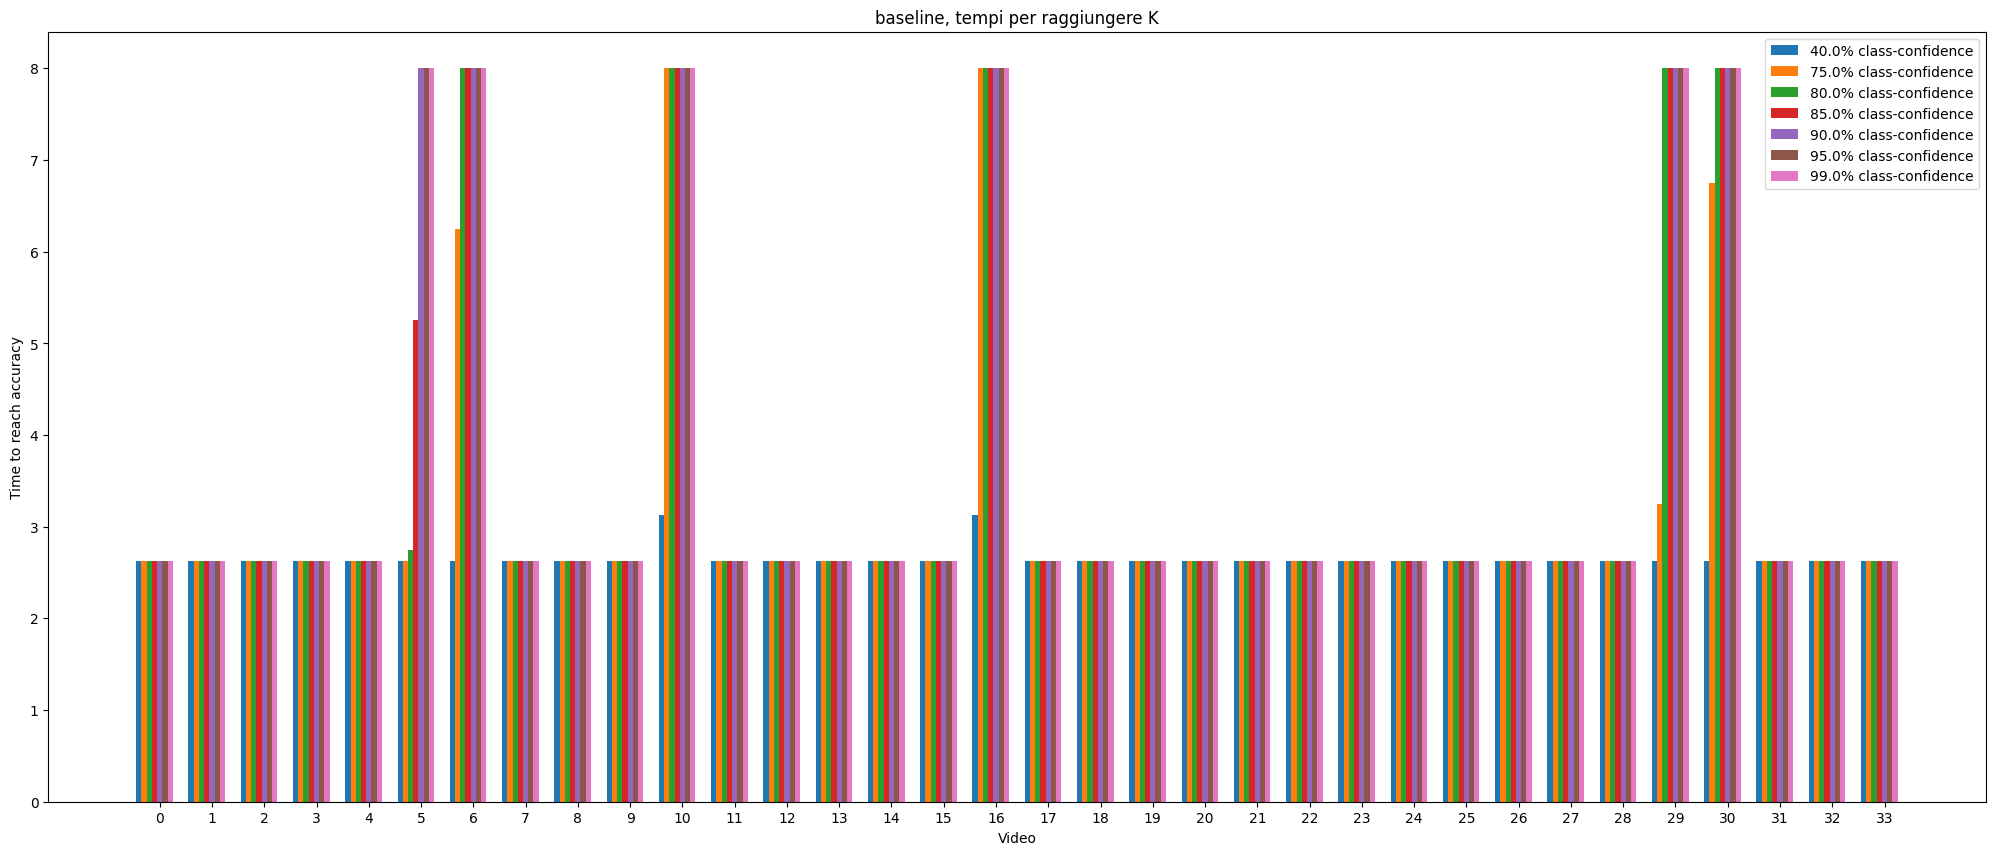

In [135]:
bar_width = 0.1

x = np.arange(len(real_video_classes))
my_xticks = real_video_classes
fig, ax = plt.subplots(figsize=(25, 10))

for k in range(0, len(classification_confidence_list)):
  ax.bar(x + (k * bar_width), times_baseline[k], width=bar_width)
# Ho dovuto settare la scala logaritmica perchè altrimenti i valori molto piccoli non sarebbero stati visibili sul grafico
#ax.set(yscale='log', xlabel='Video', ylabel='Time to activate', title='y with log scale')
ax.set(xlabel='Video', ylabel='Time to reach accuracy', title='baseline, time to reach K')
ax.set_xticks(x + bar_width * 4)
ax.set_xticklabels([counter for counter in range(0, len(real_video_classes))])
ax.legend(percents)

plt.savefig(f"{plot_directory}/{times_plot_name}_{cc_plot_name}_{per_video_plot_name}.png")
plt.show()

## MCS

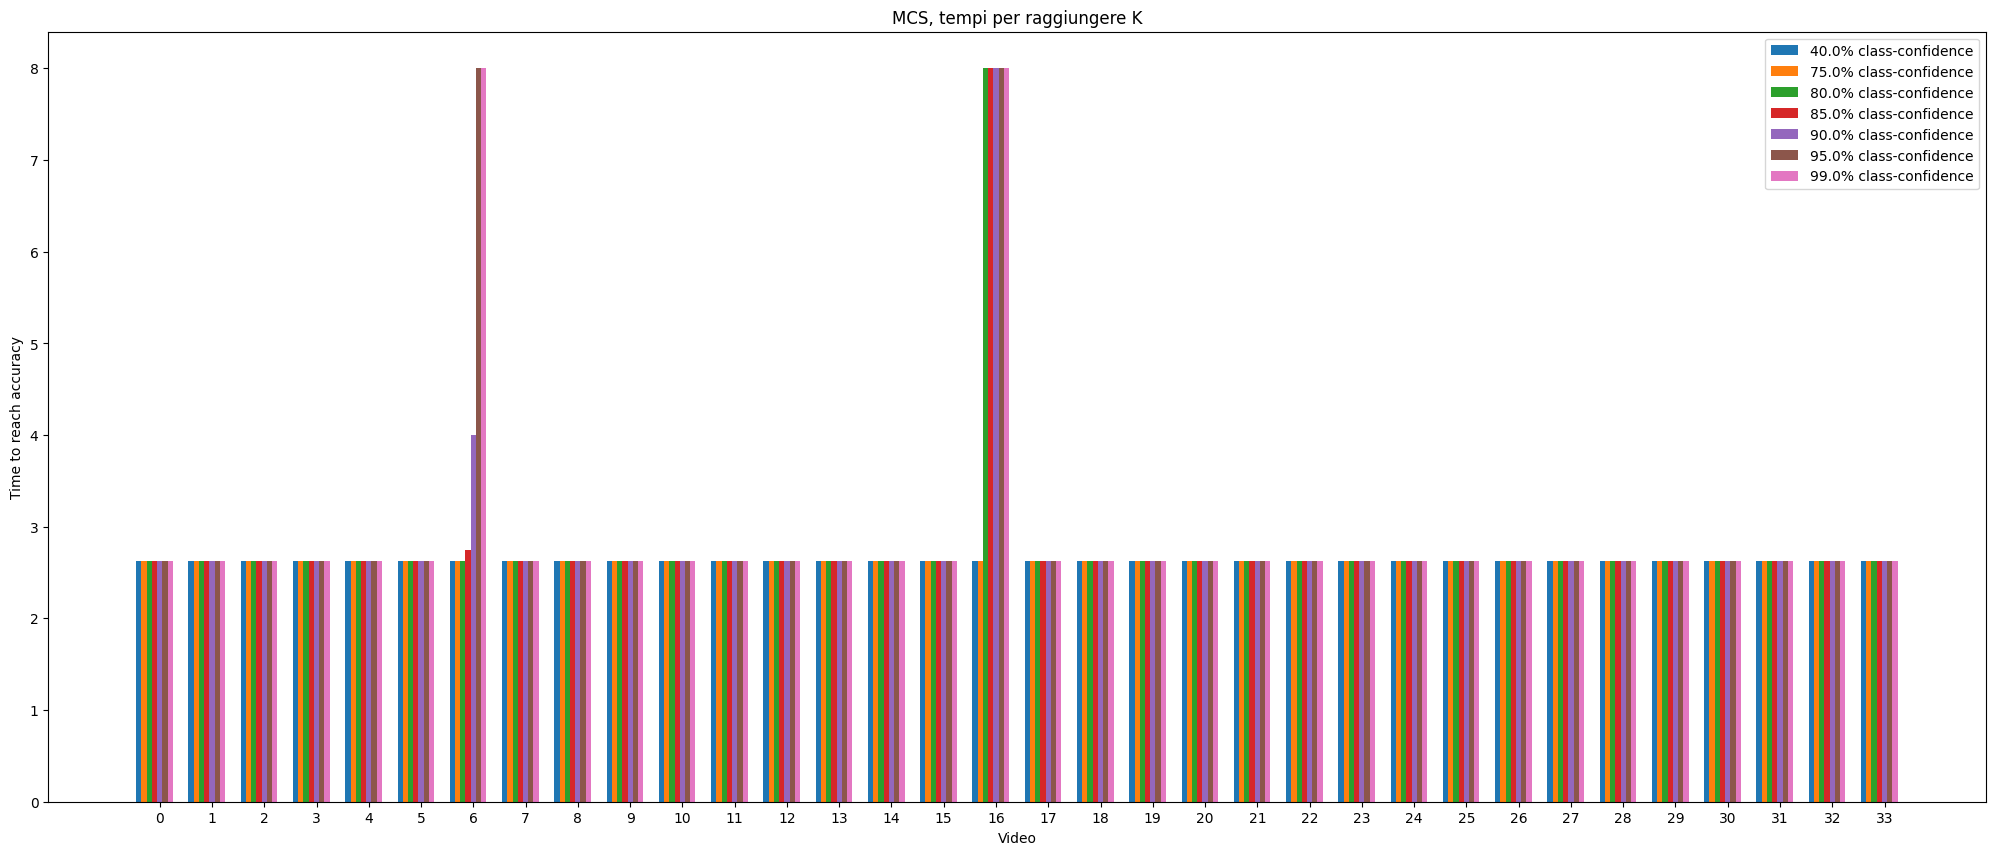

In [136]:
bar_width = 0.1

x = np.arange(len(real_video_classes))
my_xticks = real_video_classes
fig, ax = plt.subplots(figsize=(25, 10))

for k in range(0, len(classification_confidence_list)):
  ax.bar(x + (k * bar_width), times_MCS[k], width=bar_width)
# Ho dovuto settare la scala logaritmica perchè altrimenti i valori molto piccoli non sarebbero stati visibili sul grafico
#ax.set(yscale='log', xlabel='Video', ylabel='Time to activate', title='y with log scale')
ax.set(xlabel='Video', ylabel='Time to reach accuracy', title='MCS, time to reach K')
ax.set_xticks(x + bar_width * 4)
ax.set_xticklabels([counter for counter in range(0, len(real_video_classes))])
ax.legend(percents)

plt.savefig(f"{plot_directory}/{times_plot_name}_{mcs_plot_name}_{per_video_plot_name}.png")
plt.show()

## MCSwT

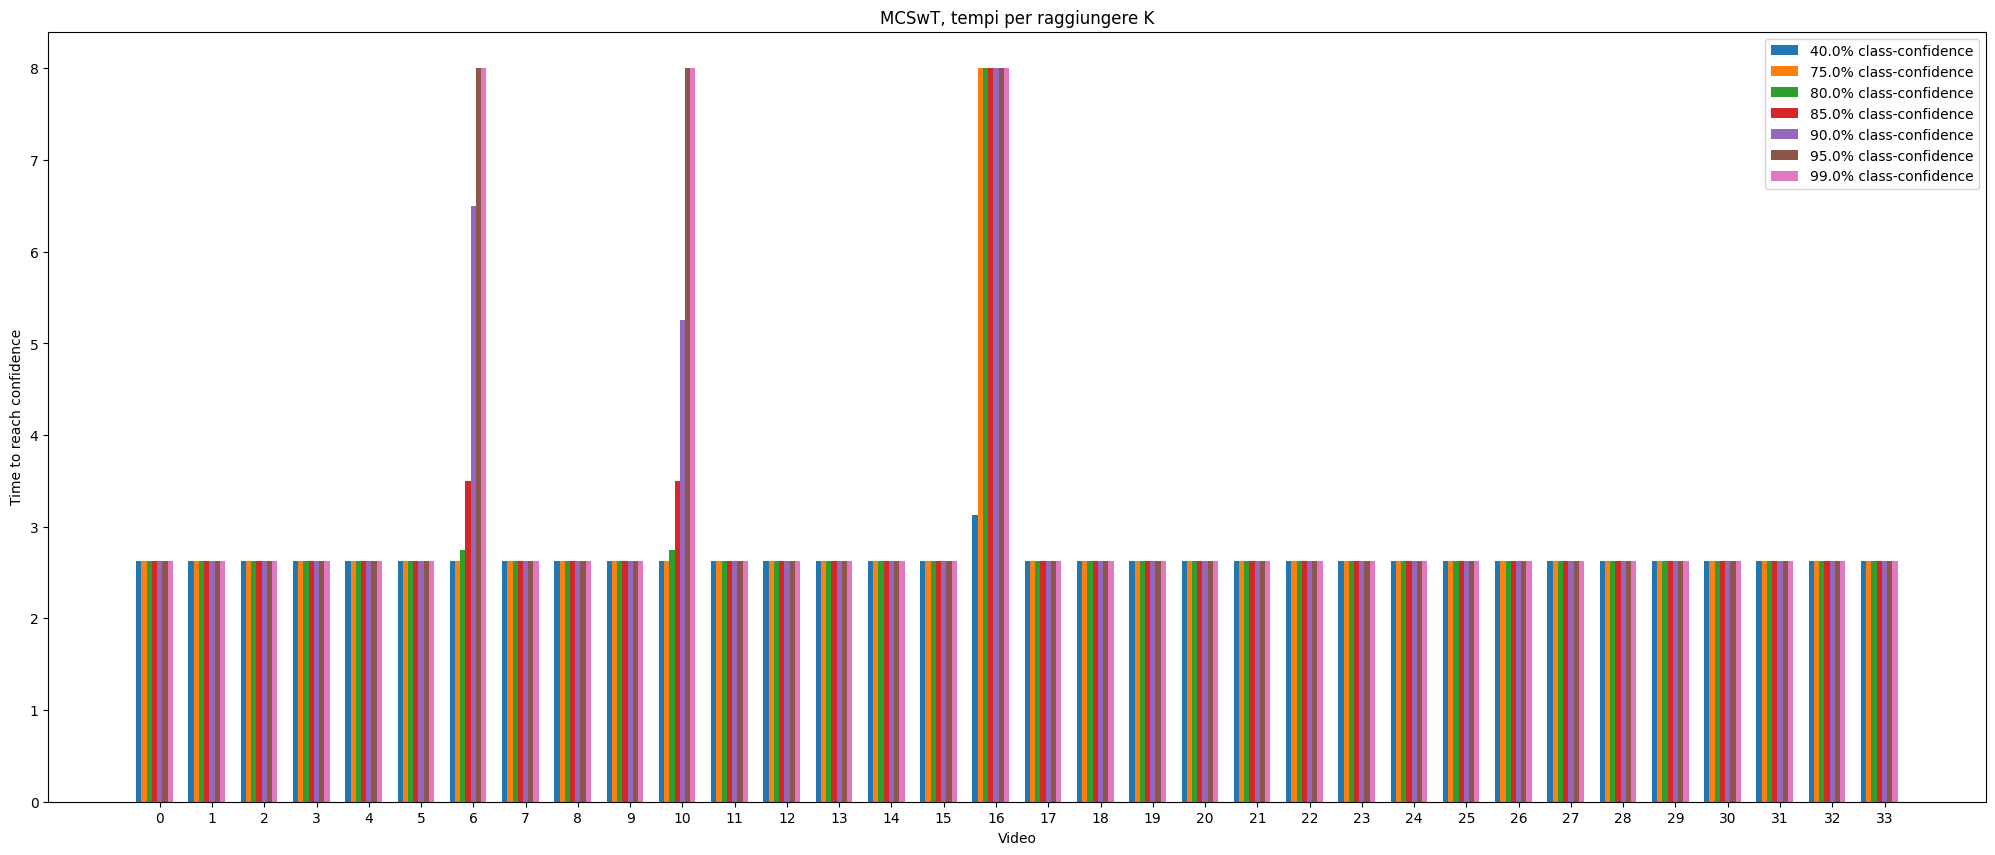

In [137]:
bar_width = 0.1

x = np.arange(len(real_video_classes))
my_xticks = real_video_classes
fig, ax = plt.subplots(figsize=(25, 10))

for k in range(0, len(classification_confidence_list)):
  ax.bar(x + (k * bar_width), times_MCSwT[k], width=bar_width)
# Ho dovuto settare la scala logaritmica perchè altrimenti i valori molto piccoli non sarebbero stati visibili sul grafico
#ax.set(yscale='log', xlabel='Video', ylabel='Time to activate', title='y with log scale')
ax.set(xlabel='Video', ylabel='Time to reach confidence', title='MCSwT, time to reach K')
ax.set_xticks(x + bar_width * 4)
ax.set_xticklabels([counter for counter in range(0, len(real_video_classes))])
ax.legend(percents)

plt.savefig(f"{plot_directory}/{times_plot_name}_{MCSwT_plot_name}_{per_video_plot_name}.png")
plt.show()

# Comparison of Means

## Facciamo la media di tutti i tempi di attivazione degli $n$ video

In [138]:
# importing mean()
from statistics import mean

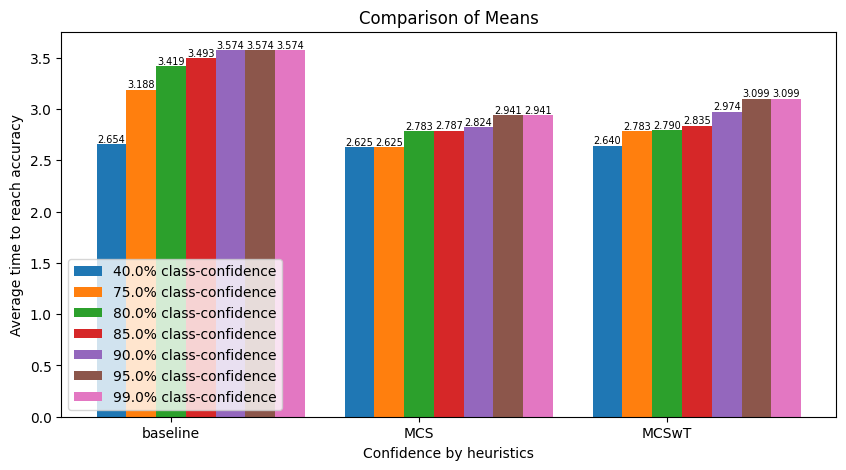

In [139]:
bar_width = 0.12

x = np.arange(len(heuristics))
my_xticks = real_video_classes
fig, ax = plt.subplots(figsize=(10, 5))

times_cc_array_of_means = np.empty(0)
times_MCS_array_of_means = np.empty(0)
times_MCSwT_array_of_means = np.empty(0)

# Initialize arrays to store variances
variances_cc_array = []
variances_MCS_array = []
variances_MCSwT_array = []

for k in range(0, len(classification_confidence_list)):
  times_baseline_mean = 0
  times_MCS_mean = 0
  times_MCSwT_mean = 0
  counter_baseline_mean = 0
  counter_MCS_mean = 0
  counter_MCSwT_mean = 0
  empty_column = False

  for j in range(0, n):
    times_baseline_mean += times_baseline[k][j]
    times_MCS_mean += times_MCS[k][j]
    times_MCSwT_mean += times_MCSwT[k][j]

  times_baseline_mean /= n
  times_MCS_mean /= n
  times_MCSwT_mean /= n

  times_cc_array_of_means = np.append(times_cc_array_of_means, times_baseline_mean)
  times_MCS_array_of_means = np.append(times_MCS_array_of_means, times_MCS_mean)
  times_MCSwT_array_of_means = np.append(times_MCSwT_array_of_means, times_MCSwT_mean)

  # Calculate variances
  variance_cc = np.var(times_baseline[k])
  variance_MCS = np.var(times_MCS[k])
  variance_MCSwT = np.var(times_MCSwT[k])

  # Append variances to arrays
  variances_cc_array.append(variance_cc)
  variances_MCS_array.append(variance_MCS)
  variances_MCSwT_array.append(variance_MCSwT)


times_cc_array_of_means = times_cc_array_of_means.reshape((len(classification_confidence_list), 1))
times_MCS_array_of_means = times_MCS_array_of_means.reshape((len(classification_confidence_list), 1))
times_MCSwT_array_of_means = times_MCSwT_array_of_means.reshape((len(classification_confidence_list), 1))
data = np.stack([times_cc_array_of_means, times_MCS_array_of_means, times_MCSwT_array_of_means]).reshape((len(heuristics), len(classification_confidence_list)))
data = data.transpose()

for k in range(0, len(classification_confidence_list)):
  bar_container = ax.bar(x + (k * bar_width), data[k], width=bar_width)
  ax.bar_label(bar_container, fmt='{:,.3f}', fontsize=7)
ax.set(xlabel='Confidence by heuristics', ylabel='Average time to reach accuracy', title='Comparison of Means')
ax.legend(percents, loc='lower left')
ax.set_xticks(x + bar_width * 2)
ax.set_xticklabels([heuristic for heuristic in heuristics])

plt.savefig(f"{plot_directory}/{times_plot_name}_{avg_plot_name}.png")
plt.show()

## Boxplot dei tempi di attivazione
Nei grafici a seguire verrano creati tanti boxplot quante sono le soglie attivazione $K$ (quindi se `classification_confidence_list=[0.5, 0.7, 0.9]` allora verrano creati 3 boxplot) in modo tale da studiare la distribuzione dei tempi per ogni soglia $K$.

In [140]:
times_baseline_list = []
times_MCS_list = []
times_MCSwT_list = []

all_times_baseline_list = []
all_times_MCS_list = []
all_times_MCSwT_list = []

for k in range(0, len(classification_confidence_list)):
  times_baseline_list.append(times_baseline[k].tolist())
  times_MCS_list.append(times_MCS[k].tolist())
  times_MCSwT_list.append(times_MCSwT[k].tolist())
  for video_index in range(0, n):
    all_times_baseline_list.append(times_baseline[k][video_index])
    all_times_MCS_list.append(times_MCS[k][video_index])
    all_times_MCSwT_list.append(times_MCSwT[k][video_index])

## baseline (baseline)

In [141]:
for i in range(0, len(classification_confidence_list)):
  print(times_baseline_list[i])

[2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 3.125, 2.625, 2.625, 2.625, 2.625, 2.625, 3.125, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625]
[2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 6.25, 2.625, 2.625, 2.625, 8.0, 2.625, 2.625, 2.625, 2.625, 2.625, 8.0, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 3.25, 6.75, 2.625, 2.625, 2.625]
[2.625, 2.625, 2.625, 2.625, 2.625, 2.75, 8.0, 2.625, 2.625, 2.625, 8.0, 2.625, 2.625, 2.625, 2.625, 2.625, 8.0, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 8.0, 8.0, 2.625, 2.625, 2.625]
[2.625, 2.625, 2.625, 2.625, 2.625, 5.25, 8.0, 2.625, 2.625, 2.625, 8.0, 2.625, 2.625, 2.625, 2.625, 2.625, 8.0, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 8.0, 8.0, 2.625, 2.625, 2.625]
[2.625, 2.625, 2.625, 2.625, 2.625, 8.0, 8.0, 2.625, 2.625, 2.625, 8.0, 2

In [ ]:
# Creazione di una figura per i boxplot verticali
fig, ax = plt.subplots(figsize=(15, 10))

# Creazione dei boxplot verticali
bp = ax.boxplot(times_baseline_list, vert=True, showfliers=False)
points = []
for i in range(0, len(classification_confidence_list)):
  y = times_baseline_list[i]
  x = np.random.normal(1+i, 0.07, size=len(y))
  points.append(plt.scatter(x, y, alpha=0.4))
ax.legend(points, percents, loc='center left')
# Mostra il grafico

plt.savefig(f"{plot_directory}/{times_plot_name}_{boxplot_plot_name}_{cc_plot_name}_{per_acc_plot_name}.png")
plt.show()

## MCS

In [143]:
for i in range(0, len(classification_confidence_list)):
  print(times_MCS_list[i])

[2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625]
[2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625]
[2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 8.0, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625]
[2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.75, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 8.0, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625]
[2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 4.0, 2

In [ ]:
# Creazione di una figura per i boxplot verticali
fig, ax = plt.subplots(figsize=(15, 10))

# Creazione dei boxplot verticali
bp = ax.boxplot(times_MCS_list, vert=True, showfliers=False)
points = []
for i in range(0, len(classification_confidence_list)):
  y = times_MCS_list[i]
  x = np.random.normal(1+i, 0.1, size=len(y))
  points.append(plt.scatter(x, y, alpha=0.4))
ax.legend(points, percents, loc='center left')
# Mostra il grafico

plt.savefig(f"{plot_directory}/{times_plot_name}_{boxplot_plot_name}_{mcs_plot_name}_{per_acc_plot_name}.png")
plt.show()

## MCSwT

In [145]:
for i in range(0, len(classification_confidence_list)):
  print(times_MCSwT_list[i])
  if i == len(classification_confidence_list) - 1:
    print(np.sum(times_MCSwT_list[i]))

[2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 3.125, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625]
[2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 8.0, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625]
[2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.75, 2.625, 2.625, 2.625, 2.75, 2.625, 2.625, 2.625, 2.625, 2.625, 8.0, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625]
[2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 3.5, 2.625, 2.625, 2.625, 3.5, 2.625, 2.625, 2.625, 2.625, 2.625, 8.0, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 2.625]
[2.625, 2.625, 2.625, 2.625, 2.625, 2.625, 6.5, 2.625, 2

In [ ]:
# Creazione di una figura per i boxplot verticali
fig, ax = plt.subplots(figsize=(15, 10))

# Creazione dei boxplot verticali
bp = ax.boxplot(times_MCSwT_list, vert=True, showfliers=False)
points = []
for i in range(0, len(classification_confidence_list)):
  y = times_MCSwT_list[i]
  x = np.random.normal(1+i, 0.04, size=len(y))
  points.append(plt.scatter(x, y, alpha=0.4))
ax.legend(points, percents, loc='center left')
# Mostra il grafico

plt.savefig(f"{plot_directory}/{times_plot_name}_{boxplot_plot_name}_{MCSwT_plot_name}_{per_acc_plot_name}.png")
plt.show()

## Confronto tra boxplot: tempi aggregati
Il seguente grafico considera la distribuzione dei tempi di attivazione aggregati per euristica (quindi non più per soglia di attivazione $K$).
In questo modo possiamo visualizzare la distribuzione dei tempi in base alle euristiche utilizzate.

In [ ]:
data = [all_times_baseline_list, all_times_MCS_list, all_times_MCSwT_list]
fig, ax = plt.subplots(figsize=(10, 6))
# Creazione dei boxplot verticali
bp = ax.boxplot(data, showfliers=False, vert=False)
points = []
for i in range(0, len(heuristics)):
  x = data[i]
  y = np.random.normal(i+1, 0.1, size=len(x))
  points.append(plt.scatter(x, y, alpha=0.4))
ax.legend(points, heuristics, loc='center')

# Mostra il grafico

plt.savefig(f"{plot_directory}/{times_plot_name}_{boxplot_plot_name}.png")
plt.show()

## Numero di video che non hanno raggiunto l'accuracy
Dai grafici precedenti sembrerebbe che tutti i video abbiamo raggiunto tutte le accuracy che sono state analizzate: non è così. \\
Il problema è che alcune volte il meccanismo di registrazione del tempo impiegato al raggiungimento di una determinata soglia di accuracy non riesce ad attivarsi proprio perchè l'accuracy non è abbastanza.

Per questo abbiamo deciso in fase di sviluppo di aggiungere una costante (la durata del video in questione, $\text{sec}$) qualora vi fossero video che non raggiungessero tale accuracy.

Nel grafico a seguire catturiamo quello che non siamo riusciti a catturare: quanti video non hanno raggiunto l'accuracy.

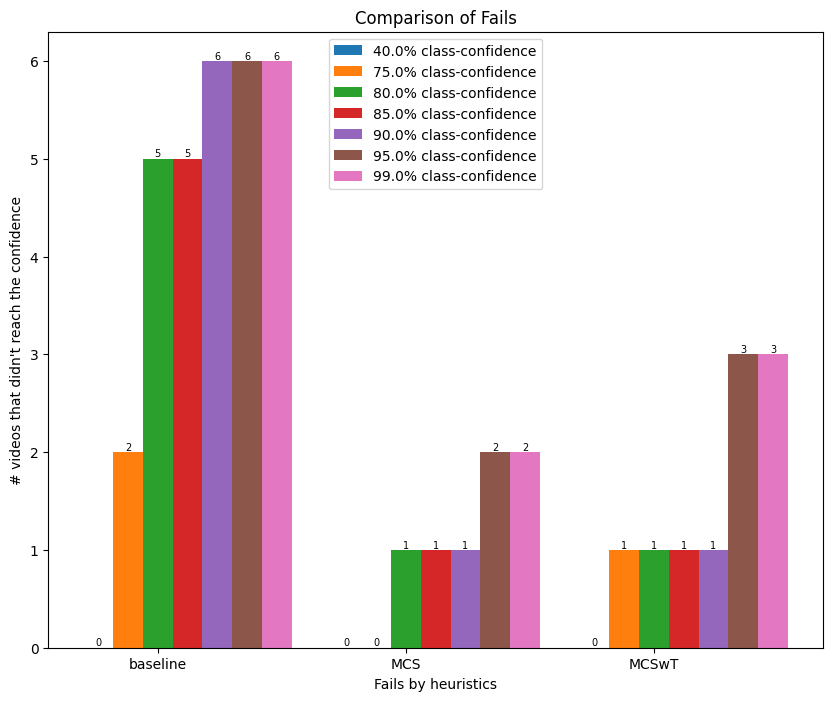

In [148]:
x = np.arange(len(heuristics))

fig, ax = plt.subplots(figsize=(10, 8))
fails_baseline_array = np.array(list(fails_baseline.values())).reshape(len(classification_confidence_list), 1)
fails_MCS_array = np.array(list(fails_MCS.values())).reshape(len(classification_confidence_list), 1)
fails_MCSwT_array = np.array(list(fails_MCSwT.values())).reshape(len(classification_confidence_list), 1)
data = np.stack([fails_baseline_array, fails_MCS_array, fails_MCSwT_array]).reshape((len(heuristics), len(classification_confidence_list)))
data = data.transpose()

for k in range(0, len(classification_confidence_list)):
  bar_container = ax.bar(x + (k * bar_width), data[k], width=bar_width)
  ax.bar_label(bar_container, fmt='{:,.0f}', fontsize=7)
ax.set(xlabel='Fails by heuristics', ylabel="# videos that didn't reach the confidence", title='Comparison of Fails')
ax.legend(percents, loc='upper center')
ax.set_xticks(x + bar_width * 2)
ax.set_xticklabels([heuristic for heuristic in heuristics])
# Rimuovi i tick sull'asse y e mostra solo valori interi
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.savefig(f"{plot_directory}/{times_plot_name}_accuracy_{fails_plot_name}.png")
plt.show()

# Grafico a barre (classificazioni frame singoli)
Nel grafico a seguire verranno messi sull'asse delle $x$ le classi (reali) $c$ dei video (e.g. $\text{passenger}$) e per ogni video vengono indicati con diversi colori il numero di frame classificati ($\text{rosso}=\text{driver}$, $\text{verde}=\text{passenger}$, $\text{blu}=\text{none}$)

In [149]:
classes = ["driver", "passenger", "none"]

## baseline (baseline)

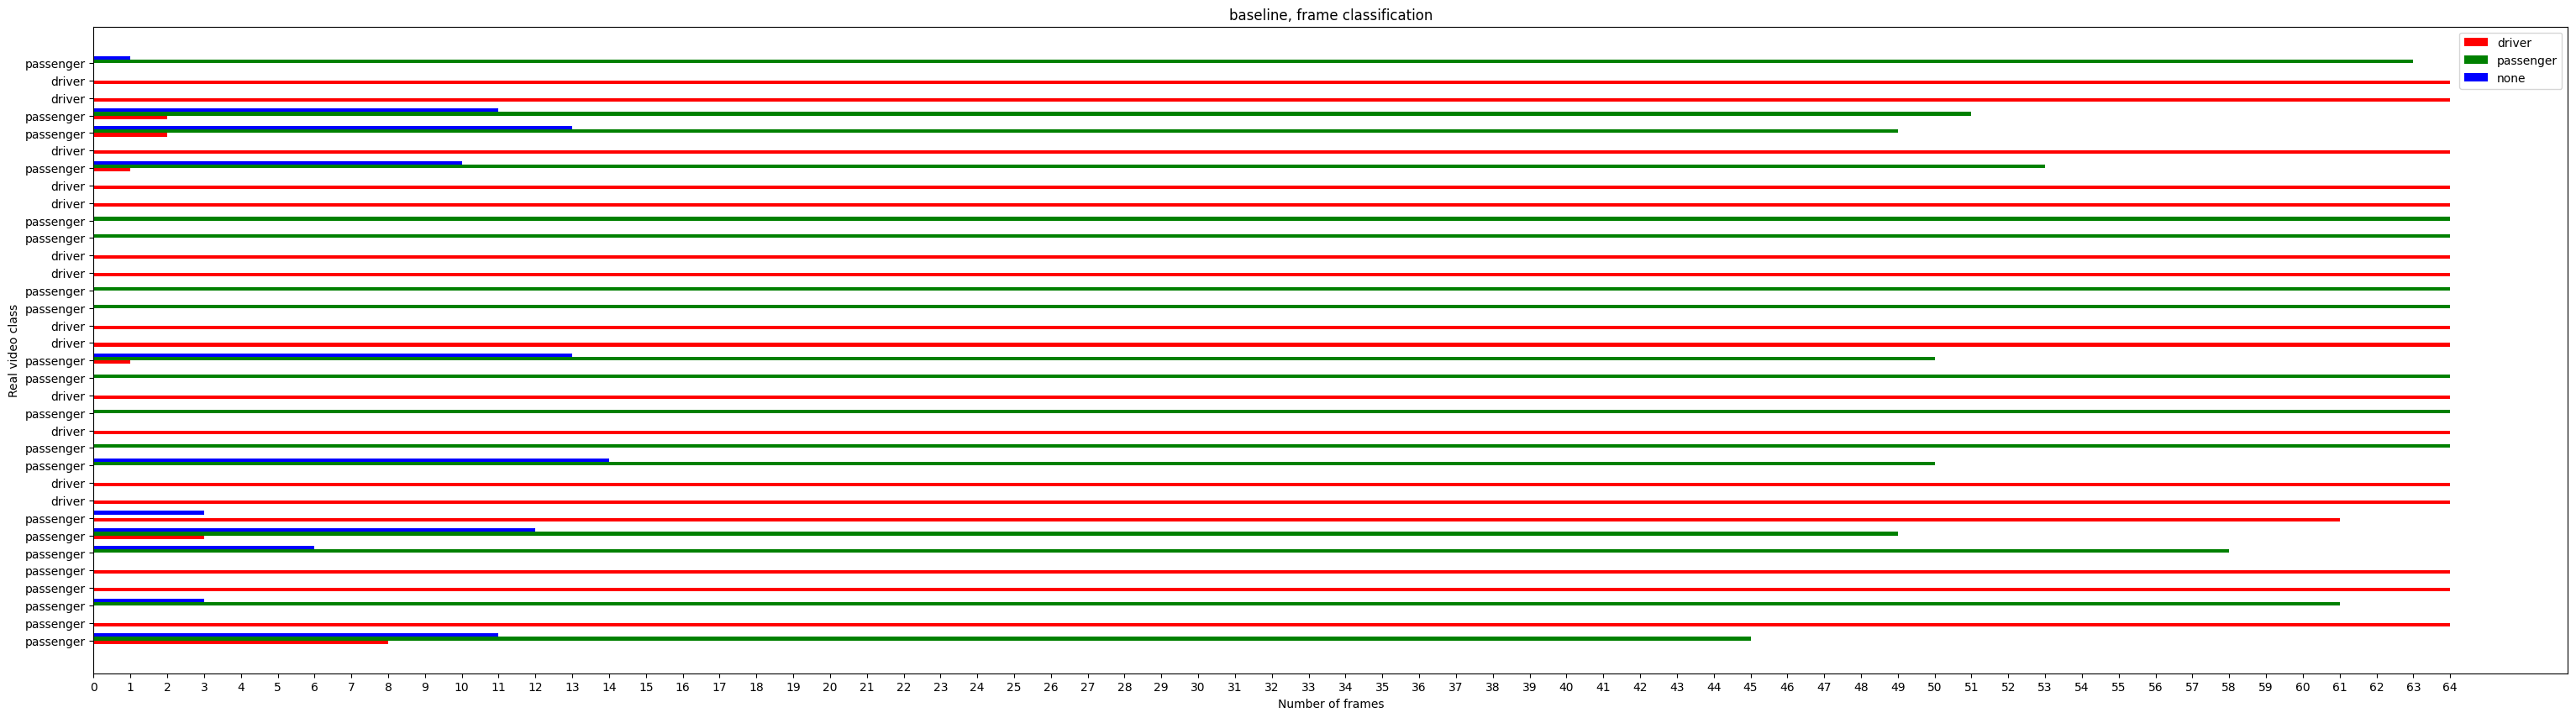

In [150]:
bar_height = 0.2

x = np.arange(len(real_video_classes))
my_xticks = real_video_classes
y = baseline_predictions.reshape((n, fps * sec))

fig, ax = plt.subplots(figsize=(38, 10))
big_df_baseline = pd.DataFrame(columns = classes)
for video_frame_predictions in y:
  my_array = np.array([
      np.count_nonzero(video_frame_predictions == "driver"),
      np.count_nonzero(video_frame_predictions == "passenger"),
      np.count_nonzero(video_frame_predictions == "none")
    ])
  df = pd.DataFrame([my_array], columns = classes)
  big_df_baseline = pd.concat([big_df_baseline, df])

ax.barh(x, big_df_baseline["driver"], height=bar_height, color='r')
ax.barh(x+bar_height, big_df_baseline["passenger"], height=bar_height, color='g')
ax.barh(x+2*bar_height, big_df_baseline['none'], height=bar_height, color='b')
ax.set_yticks(x + bar_height / 2)
ax.set_yticklabels(real_video_classes)
ax.set_xticks(np.arange(fps * sec + 1))
ax.set(xlabel='Number of frames', ylabel='Real video class', title='baseline, frame classification')
ax.legend(classes)

plt.savefig(f"{plot_directory}/{classifications_plot_name}_{cc_plot_name}_{per_video_plot_name}.png")
plt.show()

<class 'numpy.ndarray'>


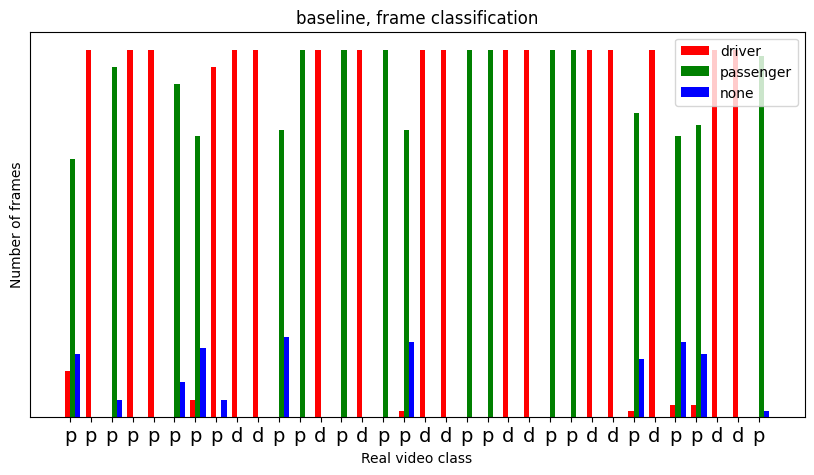

In [151]:
bar_height = 0.25

y = np.arange(len(real_video_classes))
my_xticks = real_video_classes
x = baseline_predictions.reshape((n, fps * sec))

fig, ax = plt.subplots(figsize=(10, 5))
big_df_baseline = pd.DataFrame(columns = classes)
for video_frame_predictions in x:
  my_array = np.array([
      np.count_nonzero(video_frame_predictions == "driver"),
      np.count_nonzero(video_frame_predictions == "passenger"),
      np.count_nonzero(video_frame_predictions == "none")
    ])
  df = pd.DataFrame([my_array], columns = classes)
  big_df_baseline = pd.concat([big_df_baseline, df])

ax.bar(y, big_df_baseline["driver"], width=bar_height, color='r')
ax.bar(y+bar_height, big_df_baseline["passenger"], width=bar_height, color='g')
ax.bar(y+2*bar_height, big_df_baseline['none'], width=bar_height, color='b')
ax.set_xticks(y + bar_height / 2)
f = lambda x: x[0]
my_func = np.vectorize(f)
print(type(real_video_classes))
ax.set_xticklabels(my_func(real_video_classes), fontsize=14)
#ax.set_xticks(np.arange(fps * sec + 1))
ax.set_yticks([])
ax.set(ylabel='Number of frames', xlabel='Real video class', title='baseline, frame classification')
ax.legend(classes)

plt.savefig(f"{plot_directory}/{classifications_plot_name}_{cc_plot_name}_{per_video_plot_name}_horizontal.png")
plt.show()

## MCS

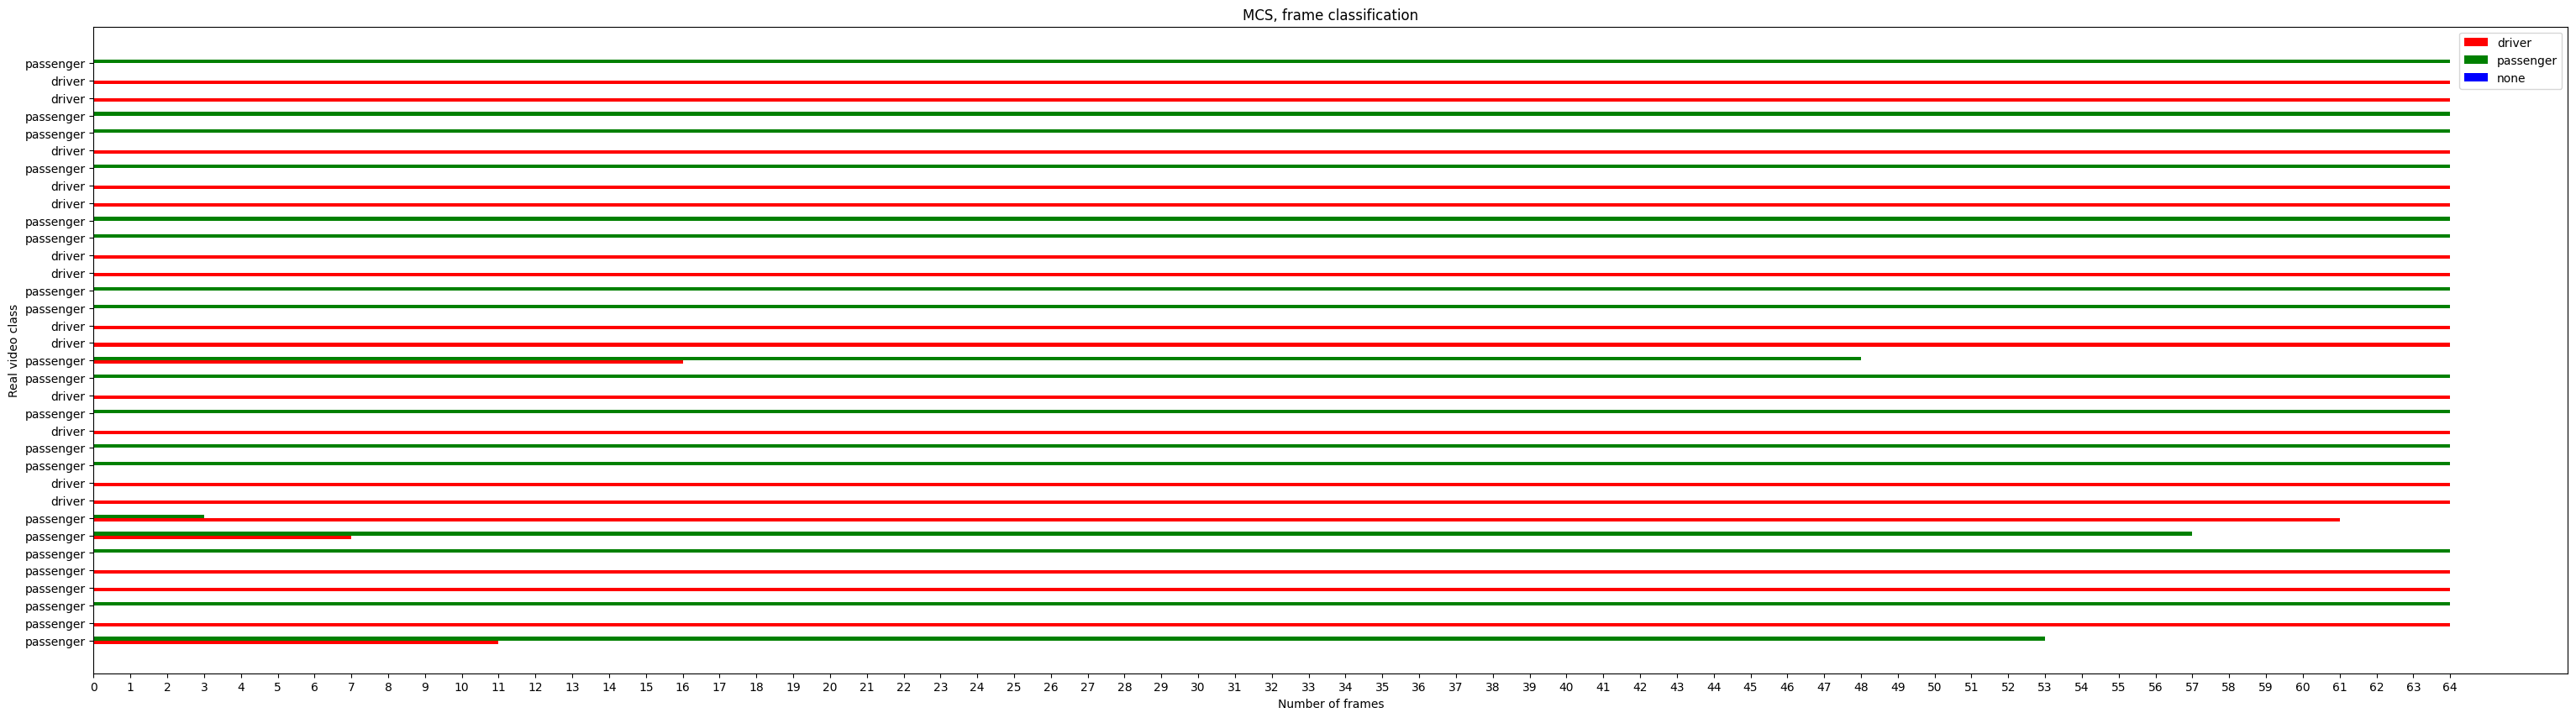

In [152]:
bar_height = 0.2

x = np.arange(len(real_video_classes))
my_xticks = real_video_classes
y = MCS_predictions.reshape((n, fps * sec))

fig, ax = plt.subplots(figsize=(38, 10))
big_df_MCS = pd.DataFrame(columns = classes)
for video_frame_predictions in y:
  my_array = np.array([
      np.count_nonzero(video_frame_predictions == "driver"),
      np.count_nonzero(video_frame_predictions == "passenger"),
      np.count_nonzero(video_frame_predictions == "none")
    ])
  df = pd.DataFrame([my_array], columns = classes)
  big_df_MCS = pd.concat([big_df_MCS, df])

ax.barh(x, big_df_MCS["driver"], height=bar_height, color='r')
ax.barh(x+bar_height, big_df_MCS["passenger"], height=bar_height, color='g')
ax.barh(x+2*bar_height, big_df_MCS['none'], height=bar_height, color='b')
ax.set_yticks(x + bar_height / 2)
ax.set_yticklabels(real_video_classes)
ax.set_xticks(np.arange(fps * sec + 1))
ax.set(xlabel='Number of frames', ylabel='Real video class', title='MCS, frame classification')
ax.legend(classes)

plt.savefig(f"{plot_directory}/{classifications_plot_name}_{mcs_plot_name}_{per_video_plot_name}.png")
plt.show()

<class 'numpy.ndarray'>


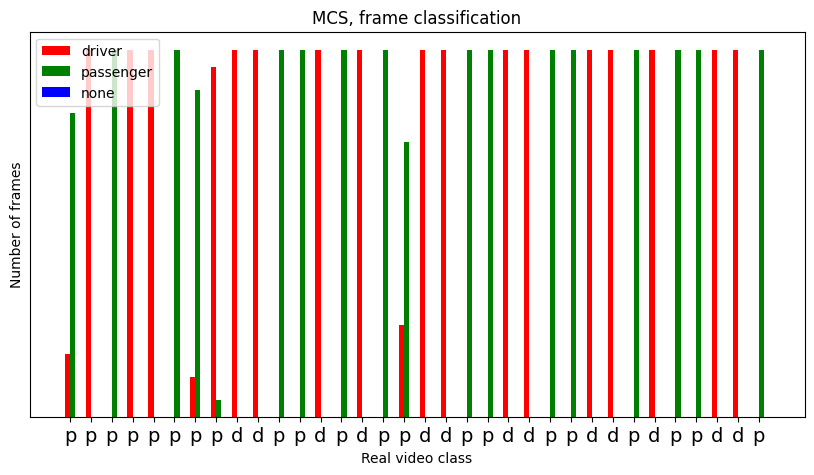

In [153]:
bar_height = 0.25

y = np.arange(len(real_video_classes))
my_xticks = real_video_classes
x = MCS_predictions.reshape((n, fps * sec))

fig, ax = plt.subplots(figsize=(10, 5))
big_df_MCS = pd.DataFrame(columns = classes)
for video_frame_predictions in x:
  my_array = np.array([
      np.count_nonzero(video_frame_predictions == "driver"),
      np.count_nonzero(video_frame_predictions == "passenger"),
      np.count_nonzero(video_frame_predictions == "none")
    ])
  df = pd.DataFrame([my_array], columns = classes)
  big_df_MCS = pd.concat([big_df_MCS, df])

ax.bar(y, big_df_MCS["driver"], width=bar_height, color='r')
ax.bar(y+bar_height, big_df_MCS["passenger"], width=bar_height, color='g')
ax.bar(y+2*bar_height, big_df_MCS['none'], width=bar_height, color='b')
ax.set_xticks(y + bar_height / 2)
f = lambda x: x[0]
my_func = np.vectorize(f)
print(type(real_video_classes))
ax.set_xticklabels(my_func(real_video_classes),fontsize=14)
#ax.set_xticks(np.arange(fps * sec + 1))
ax.set_yticks([])
ax.set(ylabel='Number of frames', xlabel='Real video class', title='MCS, frame classification')
ax.legend(classes)

plt.savefig(f"{plot_directory}/{classifications_plot_name}_{mcs_plot_name}_{per_video_plot_name}_horizontal.png")
plt.show()

## MCSwT

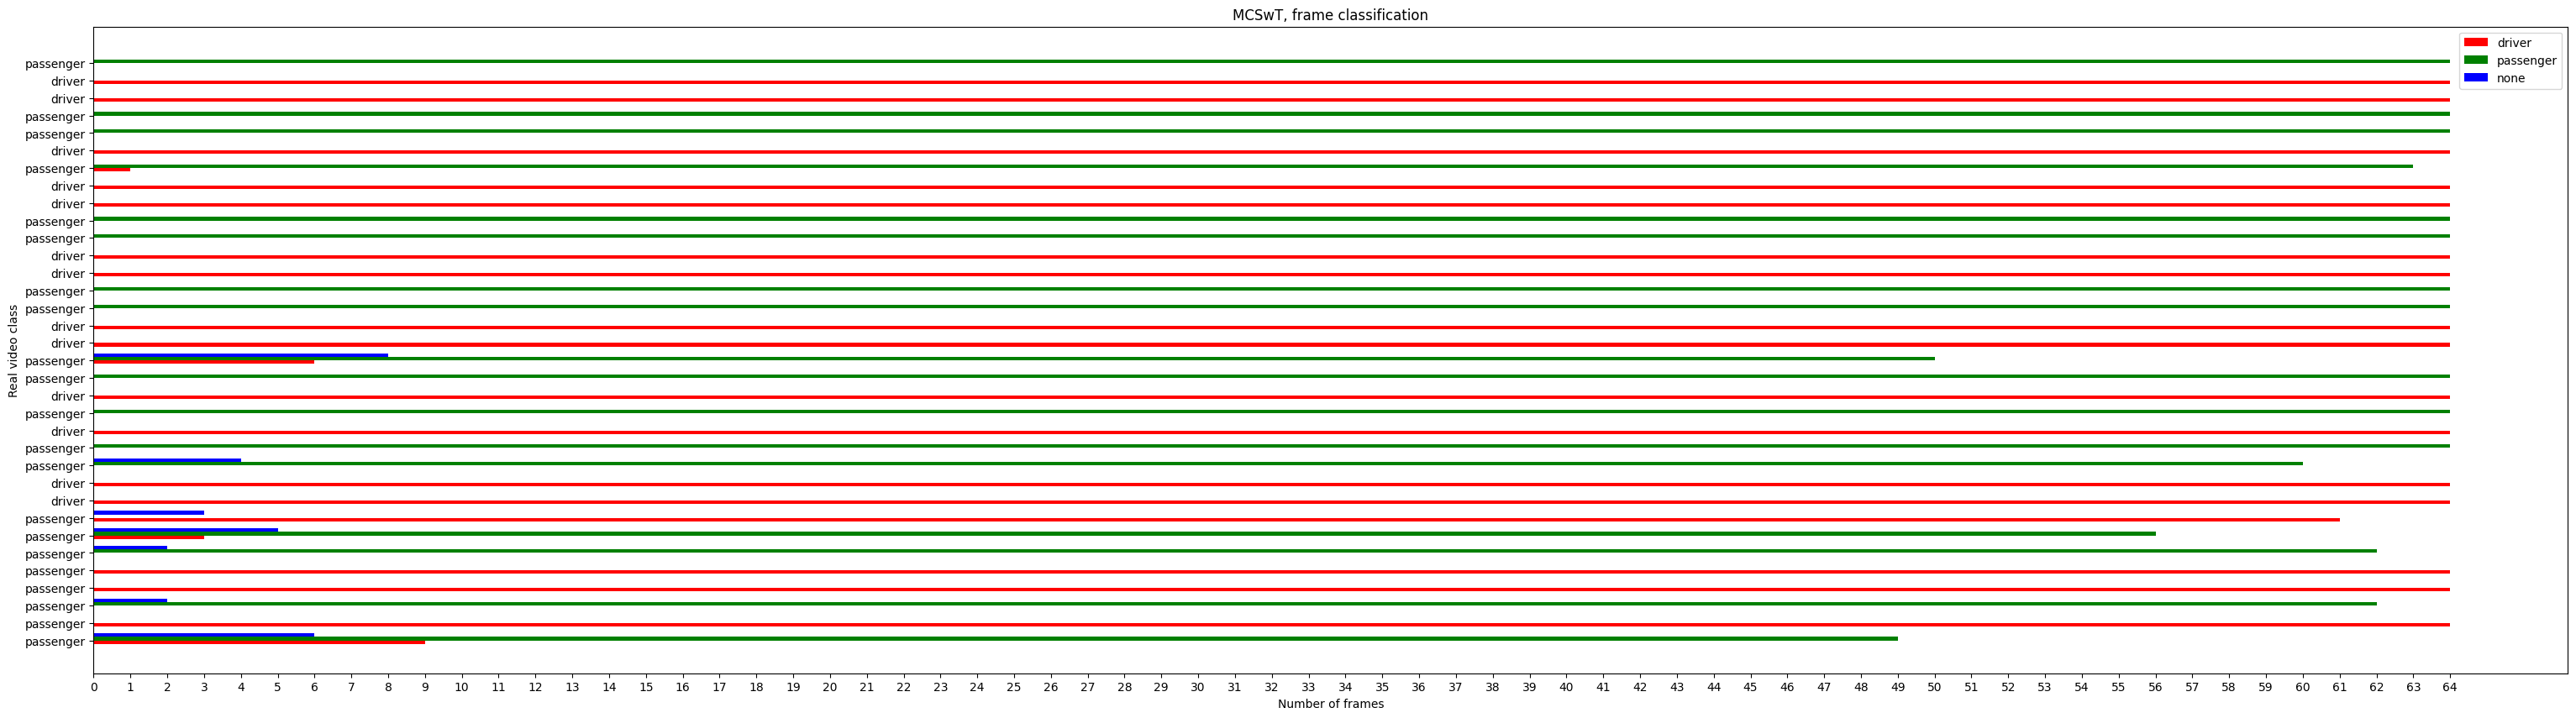

In [154]:
bar_height = 0.2

x = np.arange(len(real_video_classes))
my_xticks = real_video_classes
y = MCSwT_predictions.reshape((n, fps * sec))

fig, ax = plt.subplots(figsize=(38, 10))
big_df_MCSwT = pd.DataFrame(columns = classes)
for video_frame_predictions in y:
  my_array = np.array([
      np.count_nonzero(video_frame_predictions == "driver"),
      np.count_nonzero(video_frame_predictions == "passenger"),
      np.count_nonzero(video_frame_predictions == "none")
    ])
  df = pd.DataFrame([my_array], columns = classes)
  big_df_MCSwT = pd.concat([big_df_MCSwT, df])

ax.barh(x, big_df_MCSwT["driver"], height=bar_height, color='r')
ax.barh(x+bar_height, big_df_MCSwT["passenger"], height=bar_height, color='g')
ax.barh(x+2*bar_height, big_df_MCSwT['none'], height=bar_height, color='b')
ax.set_yticks(x + bar_height / 2)
ax.set_yticklabels(real_video_classes)
ax.set_xticks(np.arange(fps * sec + 1))
ax.set(xlabel='Number of frames', ylabel='Real video class', title='MCSwT, frame classification')
ax.legend(classes)

plt.savefig(f"{plot_directory}/{classifications_plot_name}_{MCSwT_plot_name}_{per_video_plot_name}.png")
plt.show()

<class 'numpy.ndarray'>


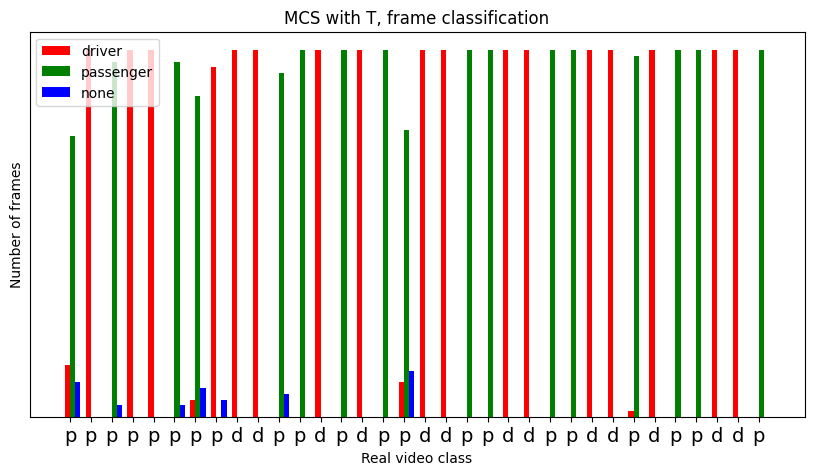

In [155]:
bar_height = 0.25

y = np.arange(len(real_video_classes))
my_xticks = real_video_classes
x = MCSwT_predictions.reshape((n, fps * sec))

fig, ax = plt.subplots(figsize=(10, 5))
big_df_MCSwT = pd.DataFrame(columns = classes)
for video_frame_predictions in x:
  my_array = np.array([
      np.count_nonzero(video_frame_predictions == "driver"),
      np.count_nonzero(video_frame_predictions == "passenger"),
      np.count_nonzero(video_frame_predictions == "none")
    ])
  df = pd.DataFrame([my_array], columns = classes)
  big_df_MCSwT = pd.concat([big_df_MCSwT, df])

ax.bar(y, big_df_MCSwT["driver"], width=bar_height, color='r')
ax.bar(y+bar_height, big_df_MCSwT["passenger"], width=bar_height, color='g')
ax.bar(y+2*bar_height, big_df_MCSwT['none'], width=bar_height, color='b')
ax.set_xticks(y + bar_height / 2)
f = lambda x: x[0]
my_func = np.vectorize(f)
print(type(real_video_classes))
ax.set_xticklabels(my_func(real_video_classes), fontsize=14)
#ax.set_xticks(np.arange(fps * sec + 1))
ax.set_yticks([])
ax.set(ylabel='Number of frames', xlabel='Real video class', title='MCS with T, frame classification')
ax.legend(classes)

plt.savefig(f"{plot_directory}/{classifications_plot_name}_{MCSwT_plot_name}_{per_video_plot_name}_horizontal.png")
plt.show()

# Grafici su dati aggregati
Considereremo la classe $\text{driver}$ come $\text{positives}$ e la classe $\text{passenger}$ come $\text{negatives}$.
## Accuracy
Si ricorda che l'accuratezza misura la frazione di predizioni corrette rispetto al numero totale di predizioni: \\
$ \text{Accuracy} = \frac{\text{correct_classifications}}{\text{all_classifications}} $

## Precision
Si ricorda che la precisione misura la frazione di predizioni positive corrette rispetto al numero totale di predizioni positive effettuate dal modello: \\
$ \text{Precision} = \frac{\text{true_posivites}}{\text{true_positives} + \text{false_positives}}$

## Recall
Si ricorda che la recall misura la frazione di predizioni positive corrette rispetto al numero totale di positivi reali: \\
$ \text{Precision} = \frac{\text{true_positives}}{\text{true_positives} + \text{false_negatives}} $

Nel nostro specifico caso d'uso, queste metriche possono essere interpretate nel seguente modo:
- accuracy: *quanti frame sono stati classificati correttamente?*
- precision: *dei frame classificati come guidatori, quanti sono veramente guidatori?*
- recall: *dei frame da guidatore, quanti siamo riusciti a classificare correttamente come guidatori?*

Viene naturale ritenere più importante avere un'alta recall, piuttosto che un'alta precision, perchè vogliamo ridurre al minor valore possibile il numero di guidatori non riconosciuti.

In [156]:
# Numero di immagini su cui applicare l'algoritmo di classificazione del video
frames = fps * sec

In [157]:
x = 0

y_activation_predictions = MCSwT_predictions.reshape((n, fps * sec))
y_MCS_predictions = MCS_predictions.reshape((n, fps * sec))
y_cc_predictions = baseline_predictions.reshape((n, fps * sec))

positive_class = "driver"
negative_class = "passenger"

acc_per_vid_MCSwT_array = np.empty(0)
acc_per_vid_mcs_array = np.empty(0)
acc_per_vid_cc_predictions_array = np.empty(0)

# True positives, False positives, False negatives
tp_fp_fn_dict = {}
for heuristic in heuristics:
  tp_fp_fn_dict[heuristic] = { "TP": 0, "FP": 0, "FN": 0 }

for index in range(0, len(y_activation_predictions)):
  video_frame_predictions_activation_predictions = y_activation_predictions[index]
  video_frame_predictions_MCS_predictions = y_MCS_predictions[index]
  video_frame_predictions_cc_predictions = y_cc_predictions[index]

  # Calcoliamo le accuracy per euristica
  vid_acc_MCSwT = np.count_nonzero(video_frame_predictions_activation_predictions == real_video_classes[index]) / frames
  vid_acc_mcs = np.count_nonzero(video_frame_predictions_MCS_predictions == real_video_classes[index]) / frames
  vid_acc_cc_predictions = np.count_nonzero(video_frame_predictions_cc_predictions == real_video_classes[index]) / frames

  # Aggiorniamo gli array delle accuracy
  acc_per_vid_MCSwT_array = np.append(acc_per_vid_MCSwT_array, vid_acc_MCSwT)
  acc_per_vid_mcs_array = np.append(acc_per_vid_mcs_array, vid_acc_mcs)
  acc_per_vid_cc_predictions_array = np.append(acc_per_vid_cc_predictions_array, vid_acc_cc_predictions)

  # Aggiorniamo i TP, FP, FN per ogni euristica che ha classificato i frame del video:
  for frame_index in range(len(video_frame_predictions_activation_predictions)):
    if video_frame_predictions_MCS_predictions[frame_index] == positive_class and real_video_classes[index] == positive_class:
      tp_fp_fn_dict[MCS_name]["TP"] += 1
    elif video_frame_predictions_MCS_predictions[frame_index] == positive_class and real_video_classes[index] == negative_class:
      tp_fp_fn_dict[MCS_name]["FP"] += 1
    elif video_frame_predictions_MCS_predictions[frame_index] == negative_class and real_video_classes[index] == positive_class:
      tp_fp_fn_dict[MCS_name]["FN"] += 1

    if video_frame_predictions_activation_predictions[frame_index] == positive_class and real_video_classes[index] == positive_class:
      tp_fp_fn_dict[MCSwT_name]["TP"] += 1
    elif video_frame_predictions_activation_predictions[frame_index] == positive_class and real_video_classes[index] == negative_class:
      tp_fp_fn_dict[MCSwT_name]["FP"] += 1
    elif video_frame_predictions_activation_predictions[frame_index] == negative_class and real_video_classes[index] == positive_class:
      tp_fp_fn_dict[MCSwT_name]["FN"] += 1


    if video_frame_predictions_cc_predictions[frame_index] == positive_class and real_video_classes[index] == positive_class:
      tp_fp_fn_dict[baseline_name]["TP"] += 1
    elif video_frame_predictions_cc_predictions[frame_index] == positive_class and real_video_classes[index] == negative_class:
      tp_fp_fn_dict[baseline_name]["FP"] += 1
    elif video_frame_predictions_cc_predictions[frame_index] == negative_class and real_video_classes[index] == positive_class:
      tp_fp_fn_dict[baseline_name]["FN"] += 1

# Calcoliamo le precision per euristica
vid_prec_MCSwT = tp_fp_fn_dict[MCSwT_name]["TP"] / (tp_fp_fn_dict[MCSwT_name]["TP"] + tp_fp_fn_dict[MCSwT_name]["FP"]) if (tp_fp_fn_dict[MCSwT_name]["TP"] + tp_fp_fn_dict[MCSwT_name]["FP"]) > 0 else 0.0
vid_prec_mcs = tp_fp_fn_dict[MCS_name]["TP"] / (tp_fp_fn_dict[MCS_name]["TP"] + tp_fp_fn_dict[MCS_name]["FP"]) if (tp_fp_fn_dict[MCS_name]["TP"] + tp_fp_fn_dict[MCS_name]["FP"]) > 0 else 0.0
vid_prec_cc = tp_fp_fn_dict[baseline_name]["TP"] /(tp_fp_fn_dict[baseline_name]["TP"] + tp_fp_fn_dict[baseline_name]["FP"]) if (tp_fp_fn_dict[baseline_name]["TP"] + tp_fp_fn_dict[baseline_name]["FP"]) > 0 else 0.0

# Calcoliamo le recall per euristica
vid_rec_MCSwT = tp_fp_fn_dict[MCSwT_name]["TP"] / (tp_fp_fn_dict[MCSwT_name]["TP"] + tp_fp_fn_dict[MCSwT_name]["FN"]) if (tp_fp_fn_dict[MCSwT_name]["TP"] + tp_fp_fn_dict[MCSwT_name]["FN"]) > 0 else 0.0
vid_rec_mcs = tp_fp_fn_dict[MCS_name]["TP"] / (tp_fp_fn_dict[MCS_name]["TP"] + tp_fp_fn_dict[MCS_name]["FN"]) if (tp_fp_fn_dict[MCS_name]["TP"] + tp_fp_fn_dict[MCS_name]["FN"]) > 0 else 0.0
vid_rec_cc = tp_fp_fn_dict[baseline_name]["TP"] / (tp_fp_fn_dict[baseline_name]["TP"] + tp_fp_fn_dict[baseline_name]["FN"]) if (tp_fp_fn_dict[baseline_name]["TP"] + tp_fp_fn_dict[baseline_name]["FN"]) > 0 else 0.0

# Accuracy

[83.13419117647058, 86.81066176470588, 86.12132352941177]


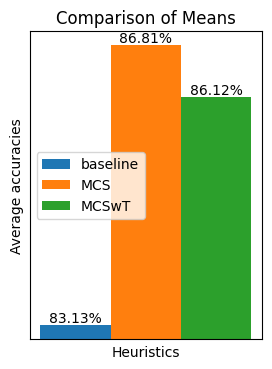

In [158]:
bar_width = 0.001
# Calcoliamo la media delle accuracy
accuracy = [mean(acc_per_vid_cc_predictions_array) * 100, mean(acc_per_vid_mcs_array) * 100, mean(acc_per_vid_MCSwT_array) * 100]
print(accuracy)
fig, ax = plt.subplots(figsize=(3, 4))
for k in range(0, len(heuristics)):
  bar_container = ax.bar(x + (k * bar_width), accuracy[k], width=bar_width)
  ax.bar_label(bar_container, fmt='{:,.2f}%', fontsize=10)
ax.set(xlabel='Heuristics', ylabel='Average accuracies', title='Comparison of Means')
ax.set_yscale('log')
ax.legend(heuristics, loc='center left')
ax.set_xticks([])
plt.minorticks_off()


plt.savefig(f"{plot_directory}/{classifications_plot_name}_accuracy_log_scale.png")
plt.show()

## Precision

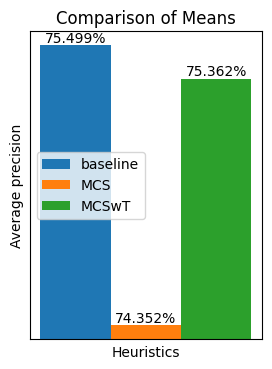

In [159]:
# Costruiamo le liste da visualizzare per la precision e recall
precision = [vid_prec_cc * 100, vid_prec_mcs * 100, vid_prec_MCSwT * 100]

fig, ax = plt.subplots(figsize=(3, 4))
for k in range(0, len(heuristics)):
  bar_container = ax.bar(x + (k * bar_width), precision[k], width=bar_width)
  ax.bar_label(bar_container, fmt='{:,.3f}%', fontsize=10)
ax.set(xlabel='Heuristics', ylabel='Average precision', title='Comparison of Means')
ax.legend(heuristics, loc='center left')
ax.set_yscale('log')
ax.set_xticks([])
plt.minorticks_off()


plt.savefig(f"{plot_directory}/{classifications_plot_name}_precision_log_scale.png")
plt.show()

## Recall

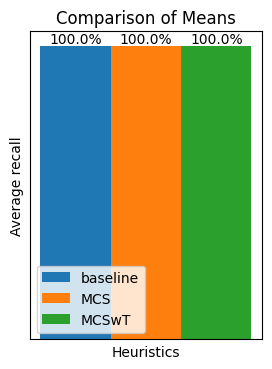

In [160]:
recall = [vid_rec_cc * 100, vid_rec_mcs * 100, vid_rec_MCSwT * 100]

fig, ax = plt.subplots(figsize=(3, 4))
for k in range(0, len(heuristics)):
  bar_container = ax.bar(x + (k * bar_width), recall[k], width=bar_width)
  ax.bar_label(bar_container, fmt='{:,.1f}%', fontsize=10)
ax.set(xlabel='Heuristics', ylabel='Average recall', title='Comparison of Means')
ax.legend(heuristics, loc='lower left')
ax.set_xticks([])
ax.set_yticks([])
plt.minorticks_off()


plt.savefig(f"{plot_directory}/{classifications_plot_name}_recall_log_scale.png")
plt.show()

In [161]:
#drive.mount('/content/gdrive')
# Salviamo tutti i grafici
#!mkdir -p {HOME}/gdrive/"MyDrive"/texting_and_driving/thesis_plots/plots_srw{start_recording_window}_ws{window_size}_{special}_mcs_with_cc/{weigth_filename}
#!cp {plot_directory}/*.png {HOME}/gdrive/"MyDrive"/texting_and_driving/thesis_plots/plots_srw{start_recording_window}_ws{window_size}_{special}_mcs_with_cc/{weigth_filename}
#!mkdir {HOME}/gdrive/"MyDrive"/texting_and_driving/plots/{weigth_filename}
#!cp {plot_directory}/*.png {HOME}/gdrive/"MyDrive"/texting_and_driving/plots/{weigth_filename}

#drive.flush_and_unmount()